In [1]:
import findspark
findspark.init('/home/ayoubgrm/spark')
#import modules
from pyspark.sql import SparkSession, functions as F
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import HashingTF, Tokenizer, StopWordsRemover
from pyspark.sql.functions import monotonically_increasing_id

# utilities
import re
import pickle
import numpy as np
import pandas as pd

# plotting
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt

#create Spark session
appName = "Sentiment Analysis in Spark1"
spark = SparkSession.builder.appName(appName).config("spark.some.config.option", "some-value").getOrCreate()

In [2]:
#read csv file into dataFrame with automatically inferred schema
schema = StructType([
         StructField('sentiment', IntegerType()),
         StructField('ids', StringType()),
         StructField('date', StringType(), True),
         StructField('flag', StringType(), True),
         StructField('user', StringType()),
         StructField('text', StringType())
         ])
tweets_csv = spark.read.csv('/dataset/senti140.csv', schema=schema).orderBy('user')
tweets_csv.show(truncate=False, n=3)

+---------+----------+----------------------------+--------+------------+-----------------------------------------------------+
|sentiment|ids       |date                        |flag    |user        |text                                                 |
+---------+----------+----------------------------+--------+------------+-----------------------------------------------------+
|0        |2257881753|Sat Jun 20 15:02:40 PDT 2009|NO_QUERY|000catnap000|kinda miss my mom  shouldn't have called her today...|
|4        |2058981540|Sat Jun 06 16:00:48 PDT 2009|NO_QUERY|000catnap000|can't get enough of it  http://bit.ly/134sSZ         |
|4        |2058432528|Sat Jun 06 14:55:54 PDT 2009|NO_QUERY|000catnap000|@Wumbologist hmmm...why not                          |
+---------+----------+----------------------------+--------+------------+-----------------------------------------------------+
only showing top 3 rows



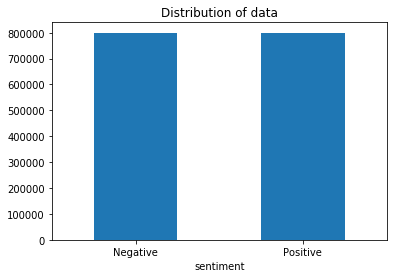

In [3]:
# converting spark dataframe to pandas
dataset = tweets_csv.select('sentiment','text').toPandas()
# Removing the unnecessary columns.
dataset = dataset[['sentiment','text']]
# Replacing the values to ease understanding.
dataset['sentiment'] = dataset['sentiment'].replace(4,1)

# Plotting the distribution for dataset.
ax = dataset.groupby('sentiment').count().plot(kind='bar', title='Distribution of data',
                                               legend=False)
ax.set_xticklabels(['Negative','Positive'], rotation=0)

# Storing data in lists.
text, sentiment = list(dataset['text']), list(dataset['sentiment'])

In [4]:
# Defining dictionary containing all emojis with their meanings.
emojis = {':)': 'smile', ':-)': 'smile', ';d': 'wink', ':-E': 'vampire', '>-)':
          'evilgrin', ':(': 'sad', ':-(': 'sad', ':-<': 'sad', ':P': 'raspberry', 
          ':-O': 'surprised', ':-*': 'kissing', ':-@': 'shocked', ':-$': 'confused',
          ':-\\': 'annoyed', ':-#': 'mute', '(((H)))': 'hugs', ':-X': 'kissing',
          '`:-)': 'smile', ':^)': 'smile', ':-&': 'confused', '<:-)': 'smile', 
          ':->': 'smile', '(-}{-)': 'kissing', ':-Q': 'smoking','$_$': 'greedy',
          '@@': 'eyeroll', ':-!': 'confused', ':-D': 'smile', ':*)': 'smile',
          ':@': 'shocked',':-0': 'yell', ':-----)': 'liar', '%-(': 'confused',
          '(:I': 'egghead', '|-O': 'yawning', ':@)': 'smile', 'O.o': 'confused',
          '<(-_-)>': 'robot', 'd[-_-]b': 'dj', '~:0': 'baby', '-@--@-': 'eyeglass',
          ":'-)": 'sadsmile', '{:-)': 'smile', ';)': 'wink', ';-)': 'wink', 
          'O:-)': 'angel','O*-)': 'angel','(:-D': 'gossip', '=^.^=': 'cat'}

In [5]:
def preprocess(textdata):
    processedText = []
    
    # Defining regex patterns.
    urlPattern        = r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)"
    userPattern       = '@[^\s]+'
    alphaPattern      = "[^a-zA-Z0-9]"
    sequencePattern   = r"(.)\1\1+"
    seqReplacePattern = r"\1\1"
    
    for tweet in textdata:
        tweet = tweet.lower()
        
        # Replace all URls with 'URL'
        tweet = re.sub(urlPattern,' URL',tweet)
        # Replace all emojis.
        for emoji in emojis.keys():
            tweet = tweet.replace(emoji, "EMOJI" + emojis[emoji])        
        # Replace @USERNAME to 'USER'.
        tweet = re.sub(userPattern,' USER', tweet)        
        # Replace all non alphabets.
        tweet = re.sub(alphaPattern, " ", tweet)        
        # Replace 3 or more consecutive letters by 2 letter.
        tweet = re.sub(sequencePattern, seqReplacePattern, tweet)
        processedText.append(tweet)
    return processedText

In [6]:
# create preprocessed spark dataframe
processedtext = preprocess(text)
dataset['text'] = processedtext
pdf = spark.createDataFrame(dataset)
pdf.show()

+---------+--------------------+
|sentiment|                text|
+---------+--------------------+
|        0|kinda miss my mom...|
|        1| USER huh uhu  i ...|
|        1|awake since six o...|
|        1|this is one of th...|
|        1|  USER hmm  why not |
|        1|can t get enough ...|
|        1|just had a facebo...|
|        1|thank god we fina...|
|        1| USER  really  lo...|
|        1|          USER why  |
|        1|is going to stone...|
|        1|  USER i luv it too |
|        0|ahh EMOJIshocked ...|
|        0| USER i sit here ...|
|        0|at work going men...|
|        0|nearlly finished ...|
|        0|today was not a g...|
|        1|i am special aren...|
|        1|another lovely da...|
|        1|had  great weeken...|
+---------+--------------------+
only showing top 20 rows



In [7]:
#divide data, 70% for training, 30% for testing
dividedData = pdf.randomSplit([0.7, 0.3]) 
trainingData = dividedData[0] #index 0 = data training
testingData = dividedData[1] #index 1 = data testing
train_rows = trainingData.count()
test_rows = testingData.count()
print ("Training data rows:", train_rows, "; Testing data rows:", test_rows)

Training data rows: 1120034 ; Testing data rows: 479966


In [8]:
# additional spark dataframe preprocessing
# 1. tokenization
tokenizer = Tokenizer(inputCol="text", outputCol="SentimentWords")
tokenizedTrain = tokenizer.transform(trainingData)
tokenizedTrain.show(truncate=False, n=5)

+---------+------------------------------------------------------------------------------------------------------------------+---------------------------------------------------------------------------------------------------------------------------------------------+
|sentiment|text                                                                                                              |SentimentWords                                                                                                                               |
+---------+------------------------------------------------------------------------------------------------------------------+---------------------------------------------------------------------------------------------------------------------------------------------+
|0        |  24 hours preparation  which means a lot of pressure  so my german exam actually starts on monday at 8am         |[, , 24, hours, preparation, , which, means, a, lot, of, pressure, 

In [9]:
# 2. remove stop words
swr = StopWordsRemover(inputCol=tokenizer.getOutputCol(), 
                       outputCol="MeaningfulWords")
SwRemovedTrain = swr.transform(tokenizedTrain)
SwRemovedTrain.show(truncate=False, n=5)

+---------+------------------------------------------------------------------------------------------------------------------+---------------------------------------------------------------------------------------------------------------------------------------------+---------------------------------------------------------------------------------------------------+
|sentiment|text                                                                                                              |SentimentWords                                                                                                                               |MeaningfulWords                                                                                    |
+---------+------------------------------------------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------------------------------------------

In [10]:
# Converting words feature into numerical feature
hashTF = HashingTF(inputCol=swr.getOutputCol(), outputCol="features")
numericTrainData = hashTF.transform(SwRemovedTrain).select(
    'sentiment', 'MeaningfulWords', 'features')
numericTrainData.show(truncate=False, n=3)

+---------+---------------------------------------------------------------------------------------------------+------------------------------------------------------------------------------------------------------------------------------------------------------+
|sentiment|MeaningfulWords                                                                                    |features                                                                                                                                              |
+---------+---------------------------------------------------------------------------------------------------+------------------------------------------------------------------------------------------------------------------------------------------------------+
|0        |[, , 24, hours, preparation, , means, lot, pressure, , german, exam, actually, starts, monday, 8am]|(262144,[65368,66864,87885,94522,96266,127844,132975,138281,158069,222966,245599,249180,257389],[1.0

In [11]:
# Train our classifier model using training data
lr = LogisticRegression(labelCol="sentiment", featuresCol="features", 
                        maxIter=10, regParam=0.01)
model = lr.fit(numericTrainData)
print ("Training is done!")

Training is done!


In [12]:
# Prepare testing data
tokenizedTest = tokenizer.transform(testingData)
SwRemovedTest = swr.transform(tokenizedTest)
numericTest = hashTF.transform(SwRemovedTest).select(
    'sentiment', 'MeaningfulWords', 'features')
numericTest.show(truncate=False, n=2)

+---------+-------------------------------------------------------------------------------------------------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|sentiment|MeaningfulWords                                                                                              |features                                                                                                                                                                 |
+---------+-------------------------------------------------------------------------------------------------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|0        |[, , 22, 30pm, , bed, time, people]                                                                          |(26

In [13]:
# Predict testing data and calculate the accuracy model
prediction = model.transform(numericTest)
predictionFinal = prediction.select(
    "MeaningfulWords", "prediction", "sentiment")
predictionFinal.show(n=4, truncate = False)
correctPrediction = predictionFinal.filter(
    predictionFinal['prediction'] == predictionFinal['sentiment']).count()
totalData = predictionFinal.count()
print("correct prediction:", correctPrediction, ", total data:", totalData, 
      ", accuracy:", correctPrediction/totalData)

+-------------------------------------------------------------------------------------------------------------+----------+---------+
|MeaningfulWords                                                                                              |prediction|sentiment|
+-------------------------------------------------------------------------------------------------------------+----------+---------+
|[, , 22, 30pm, , bed, time, people]                                                                          |1.0       |0        |
|[, , 3, great, friendships, lost, facebook, due, friends, trippin, drama, , know, alot, , wasn, fault, lol, ]|0.0       |0        |
|[, , 95, , sure, phone, toast, , shiit]                                                                      |0.0       |0        |
|[, , url, poor, boy, autistic, , amp, , loved, water, , wish, say, died, loved, , drowning, awful]           |0.0       |0        |
+--------------------------------------------------------------------